In [7]:
%matplotlib inline
import numpy as np
import scipy as sc
import scipy.stats as st

import seaborn
import matplotlib.pyplot as plt

from stats_utils import plot_dists

# Inferencia paramétrica bayesiana

Si tenemos números grandes sobre el funcionamiento de un componente (200 fallos en 1000 días de operación), podemos aproximar bastante bien la tasa de fallos mediante la estimación de máxima verosimitud (0.2 fallos/día).

Pero, *¿qué hacemos si tenemos pocos datos?*.
La estimación de máxima verosimilitud tiene los problemas siguientes:
- Puede dar resultados descabellados:
    - Si entran tres rubios a una habitación, la estimación de máxima verosimilitud para la probabilidad de que la siguiente persona en entrar sea rubia es $P=1$, es decir: certeza _absoluta_ de que será rubio.
    - Si no nos han llamado en dos horas, la estimación de máxima verosimilitud para la tasa de llamadas es $\lambda=0$, es decir: certeza _absoluta_ de que nunca llamarán.
- No mide nuestra confianza, ni nuestra incertidumbre, en el valor obtenido.
- No podemos comparar parámetros obtenidos con muestras de distinto tamaño. 

> Miramos los comentarios de dos teléfonos en principio similares:
>    - El primero tiene 1 comentario positivo y ninguno negativo => La estimación de máxima verosimilitud para la probabilidad de satisfacción es $p^*=1$.
>    - El segundo 19 comentarios positivos y uno negativo => La estimación de máxima verosimilitud para la probabilidad de satisfacción es $p^*=19/20=0.95$.
>
> Sin embargo, parece más sensato elegir el segundo teléfono.

No es un problema de "big data" vs "small data". "Big data" puede significar que tenemos muchos procesos distintos y necesitamos conocer la tasa de Poisson de cada uno de ellos, pero tenemos pocos datos para estimar la tasa de cada proceso individual (piensa en el número de productos ofertados en una tienda online: muchos tienen pocos comentarios).

## Distribución Gamma

Otra familia de distribuciones de probabilidad **continua** para una variable real, que sólo puede tomar **valores positivos**. La vamos a usar para modelizar nuestro conocimiento (o desconocimiento) sobre la **tasa de un proceso de Poisson**.

La familia de distribuciones Gamma permite:
 - representar nuestro desconocimiento sobre el auténtico valor de la tasa 𝜆 de un proceso de Poisson.
 - actualizar nuestro conocimiento sobre el auténtico valor de 𝜆 según vamos recopilando más datos, con unas cuentas increíblemente sencillas.

*Curiosidad*: la familia Gamma también sirve para modelizar el tiempo hasta la k-ésima observación de un proceso de Poisson.

La familia `Gamma(a, b)` depende de dos parámetros:

 - **a**: parámetro de *"forma"*
 - **b**: por ahora nos contentaremos con decir que es el *inverso de la escala*.

Si observamos un proceso de Poisson con tasa λ, el tiempo T hasta la k-ésima observación sigue una distribución T~Gamma(a=k, b=λ).

Al terminar este cuaderno, daremos otra interpretación intuitiva a esos parámetros.

 - La función de densidad:
$$
f(x) = {\frac {b ^{a }}{\Gamma (a )}}x^{a -1}e^{-b x}
$$
 - La media de $X\sim Gamma(a, b)$:
$$
E[X] = \frac{a }{b}
$$
 - La varianza de $X\sim Gamma(a, b)$:
$$
Var[X] = \frac{a }{b^2}
$$

Vamos a visualizar el efecto de estos parámetros sobre la función de densidad.

Atención, en scipy stats, definimos la gamma usando los parámetros ``scale=1/b``.

In [8]:
#Con a=1, es la familia exponencial !!!
gammas = [st.gamma(a=1, scale=1/1),
          st.gamma(a=1, scale=1/2),
          st.gamma(a=1, scale=1/4)
         ]

plot_dists(gammas)

In [3]:
#Pero usando distintos valores de "a", alpha, conseguimos otras formas.
gammas = [st.gamma(a=1, scale=1/1),
          st.gamma(a=2, scale=1/1),
          st.gamma(a=3, scale=1/1)
         ]

plot_dists(gammas)

La media es $a/b$, mientras que la varianza es $a/b^2$, con lo que a mayor $b$ mayor es la información que tenemos sobre la media

### Ejercicio

Dibuja varias distribuciones Gamma con a=2 y distinta escala.

### Ejercicio

Dibuja varias distribuciones Gamma que tengan distintos $a$  y $b$, pero que tengan la misma media.
Recuerda que la media de $X\sim Gamma(a, b)$ es
$$
E[X] = \frac{a }{b}
$$

## Inferencia bayesiana con una Gamma

Os mostramos un ejemplo de uso del teorema de Bayes:

 - A priori, desconocemos la tasa de fallos de transmisión diaria $\lambda$ de un sistema de comunicaciones. Antes de recibir datos, representamos nuestra incertidumbre sobre $\lambda$ mediante una distribución Gamma:
     - Si tenemos información *a priori*, como por ejemplo que sistemas similares tienen típicamente una tasa de fallos entre 1 y 3, podemos incorporarla tomando otros valores de alpha y beta, como podría ser una  ``Gamma(a=4,b=2)``, ya que para estos valores, la media es ``a/b=2``, y la varianza es ``a/b**2=1``.
     - Si pensamos que la tasa de fallos podría ser incluso mayor, podemos usar como prior una ``Gamma(a=1,b=0.1)``, que es lo mismo que ``Gamma(a=1,scale=10)``. La dispersión es muy grande => la tasa podría ser muy grande => sabemos muy poco.
 - Según recibimos información sobre p, nuestra distribución de probabilidad sobre $\lambda$ se concentra en torno al valor real...

En este contexto, ``a`` y ``b`` se denominan **hiperparámetros**, porque determinan la distribución que sigue el **parámetro** desconocido $\lambda$.

### Ejemplo

Seis horas (0.25 días) después de poner el sistema en marcha se produce un fallo de comunicación.

La estimación de máxima verosimilitud es  𝜆=1/0.25=4  fallos al día. Sin embargo, personas de confianza nos habían asegurado que esa tasa está entre 1 y 3: ¿nos han engañado o ha sido mala suerte?.
Estudiemos ahora el problema con inferencia paramétrica bayesiana.

> El tiempo hasta el primer fallo $T$ sigue una distribución exponencial: `T~Exponencial(𝜆)`.

Desgraciadamente no conocemos `𝜆`, pero de hecho, podemos usar el **teorema de Bayes** para aprender un poco más sobre la tasa de fallos del sistema incorporando la nueva información que antes no teníamos. 

La versión del teorema de Bayes para VA continuas nos permite escribir la función de densidad condicionada de esta forma:
$$
f(𝜆|T=t)=\frac{P(T=t|𝜆)f(𝜆)}{P(T=t)}.
$$
En nuestro caso $t=0.25$  y suponemos que el parámetro 𝜆 sigue una distribución `Gamma(a,b)` para ciertos valores `a` y `b` que elegiremos más tarde.

La función de densidad, incorporando 
$$
f(𝜆|T=t)=C 𝜆 e^{-𝜆t} 𝜆^{a-1}e^{-𝜆 b}=C𝜆^a e^{-𝜆 (b+t)}
$$
$$
f(𝜆|T=0.25)=C 𝜆 e^{-𝜆0.25} 𝜆^{a-1}e^{-𝜆 b}=C𝜆^a e^{-𝜆 (b+0.25)}
$$
donde la constante $C=\frac{(b + 0.25)^{a+1}}{\Gamma(a+1)}$ es simplemente la que hace que integre $1$, pues ya sabemos que la densidad condicionada es una función de densidad.

Es decir la distribución del parámetro sabiendo la información es tambien una `Gamma(a+1,b+0.25)`.


¿Qué valores escogemos para `a` y `b`?

Probamos dos elecciones que tienen el mismo valor esperado E[𝜆]=1:
 - `Gamma(a=1,b=1)`
 - `Gamma(a=5,b=5)`

In [4]:
# Si antes del dato, nuestro conocimiento seguía una 
# Gamma(alpha=1,beta=0.1)
gammas = [st.gamma(a=1, scale=1/1),
          st.gamma(a=1+1, scale=1/(1+0.25))
         ]

plot_dists(gammas)

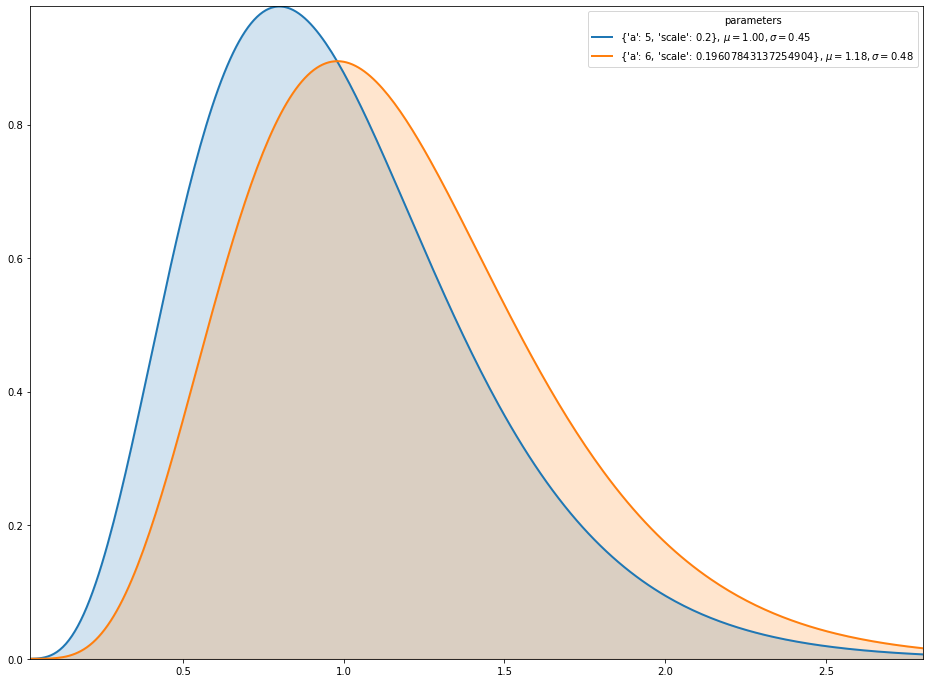

In [5]:
#Si antes del dato, nuestro conocimiento seguía una Gamma(a=5,b=2)
gammas = [st.gamma(a=5, scale=1/5),
          st.gamma(a=5+1, scale=1/(5+0.1))
         ]

plot_dists(gammas)

Observad cómo una única observación modifica sustancialmente nuestro conocimiento sobre $\lambda$ si nuestra información a priori sigue una ``Gamma(a=1,b=1)``, pero apenas modifica  el *prior* ``Gamma(a=5,b=5)``.

Intuitivamente, el prior ``Gamma(a=1,b=1)`` es *menos informativo*, corresponde a una *cantidad de evidencia menor*, mientras que el prior ``Gamma(a=5,b=5)``, es una cantidad de información a priori equivalente a cinco mediciones de una exponencial, y nuestra medición no la modifica tanto.

## Familias de distribuciones conjugadas

Dos familias de distribuciones continuas con funciones de densidad:

 - $f_{\theta_1,\dots,\theta_n}(\mu_1,\dots,\mu_m)$
 - $g_{\mu_1,\dots,\mu_m}(x)$

son conjugadas cuando, para cualquier x
$$
f_{\theta_1,\dots,\theta_n}(\mu_1,\dots,\mu_m)\cdot
g_{\mu_1,\dots,\mu_m}(x) =
C f_{\theta_1',\dots,\theta_n'}(\mu_1,\dots,\mu_m)
$$
donde C es una constante y $(\theta_1',\dots,\theta_n')$ son parámetros aceptables para la familia $f_{\theta_1',\dots,\theta_n'}$.

Hemos visto que la Gamma y la Exponencial son conjugadas (no escribimos las constantes que hacen que las funciones de densidad integren 1):

 - $f_{\alpha, \beta}(\lambda) = cte \cdot \lambda^{\alpha -1}e^{-\beta\lambda}$ (``Gamma(alpha, beta)``)
 - $g_{\lambda}(t) = cte \cdot \lambda e^{-\lambda t}$ (``Exponencial(lambda)``)

y su producto es:
$$
f_{\alpha, \beta}(\lambda)\cdot g_{\lambda}(t) = cte\cdot f_{\alpha+1, \beta+t}(\lambda)
$$

Además, **la distribución de Poisson también es conjugada de la Gamma** (ajustando la definición a una distribución continua y otra discreta...):

 - $f_{\alpha, \beta}(\lambda) = cte \cdot \lambda^{\alpha -1}e^{-\beta\lambda}$ (``Gamma(alpha, beta)``)
 - $p_{\lambda}(k) = cte \cdot \lambda \frac{\lambda^k}{k!}$ (``Poisson(lambda)``)

y su producto es:
$$
f_{\alpha, \beta}(\lambda)\cdot p_{\lambda}(k) = cte\cdot f_{\alpha+k, \beta+1}(\lambda)
$$

## Resumiendo

La regla de actualización es sencilla: 

> - Si el tiempo hasta el primer fallo es $t$, nuestro conocimiento sobre $\lambda$ evoluciona, desde una ``Gamma(a, b)`` a una ``Gamma(a+1, b+t)``.
> - Si en un día observamos $k$ fallos, nuestro conocimiento sobre la tasa de fallos diaria $\lambda$ evoluciona, desde una ``Gamma(a, b)`` a una ``Gamma(a+k, b+1)``.
> - Si en un periodo de longitud $t$ observamos $k$ fallos, nuestro conocimiento sobre $\lambda$ evoluciona, desde una ``Gamma(a, b)`` a una ``Gamma(a+k, b+t)``.

### Ejemplo

En cierto tipo de dispositivos de comunicaciones, la tasa de fallos $\lambda$ depende de cada dispositivo.

Tenemos tres dispositivos y, a priori, no sabemos cuál es mejor. Una tasa de 1 fallo / día o menor es compatible con el funcionamiento normal (si hay un sólo fallo lo vuelve a intentar), pero si la tasa es mayor es necesario reemplazar el dispositivo, que es costoso.

Tenemos tres dispositivos, que han sido probados en condiciones diferentes:

 - Uno fue probado 1 día y no falló nunca.
 - Otro fue probado 4 días y falló una vez.
 - Otro fue probado 20 veces y falló 7 veces.

Si comparamos los ratios de éxito:
 
 - el primer dispositivo tiene un promedio de fallos del $0$.
 - el segundo dispositivo tiene un promedio de fallos del $1/4=0.25$.
 - el tercer dispositivo tiene un promedio de fallos del $7/20=0.35$
 
Sin embargo, nuestra *confianza* en cada una de estas afirmaciones es distinta, porque tenemos *distinta cantidad de evidencia*.

> ¿Cuál es la probabilidad, para cada dispositivo, de que la tasa de fallos sea menor que 1 fallo al día?

A priori, pensamos que la tasa de fallos puede estar entre 0 y 4, así que ajustamos una Gamma para que tenga media 2 y desviación típica 2 (pero recordad que la Gamma no es simétrica respecto de la media...):

$$
E[X] = \frac{a }{b}, \quad Var[X] = \frac{a }{b^2}
$$
=> elegimos Gamma(a=1, b=1/2)

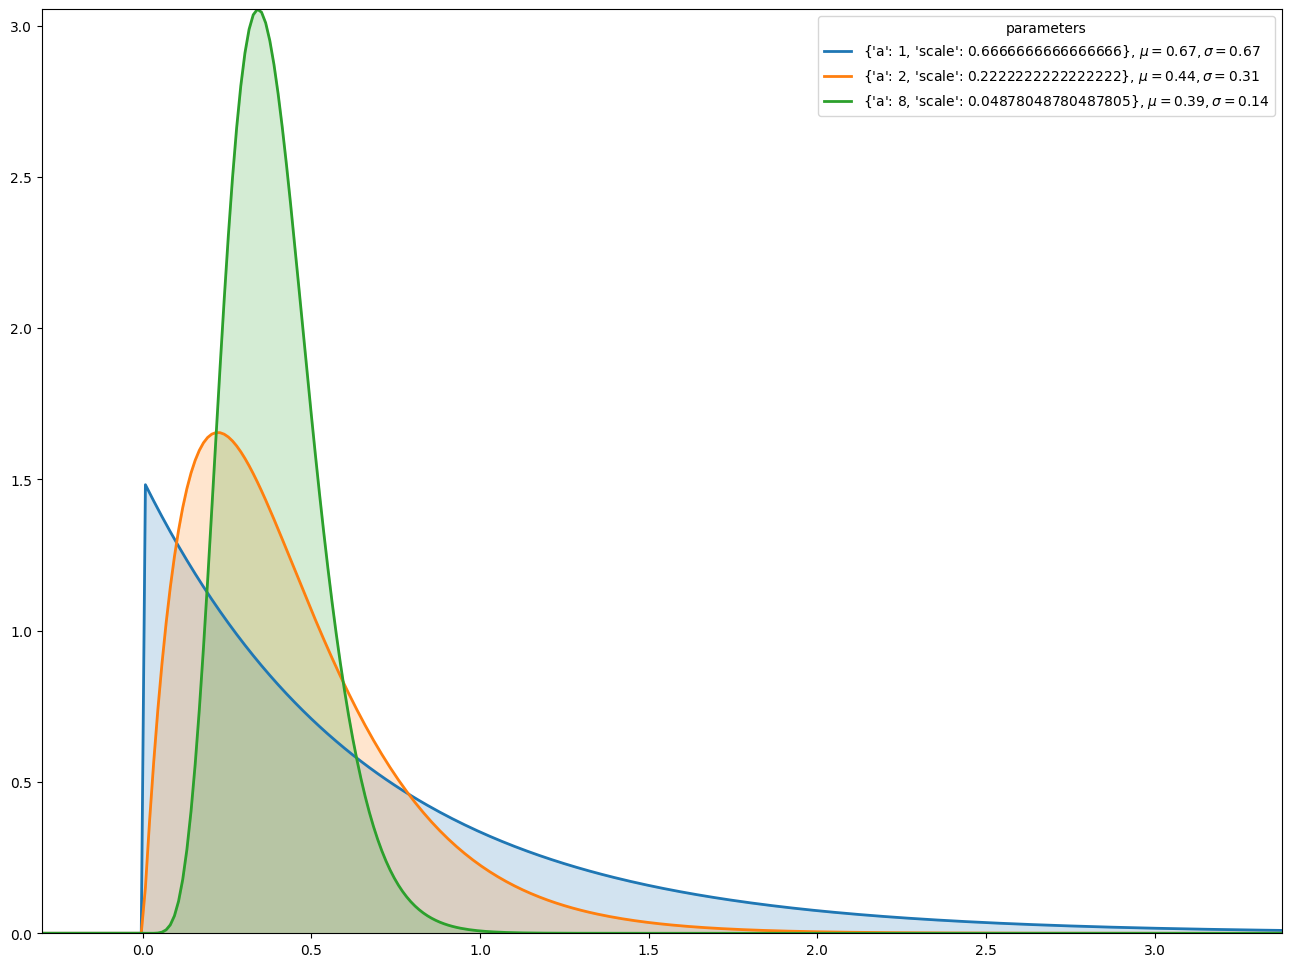

In [6]:
alpha0, beta0 = 1, 1/2
params_dispositivos = [(alpha0+k, beta0+t) for (k,t) in [
    (0,1), #0 fallos en un día
    (1,4), #1 fallos en 4 días
    (7,20), #7 fallos en 20 días
    ]]

gammas = [st.gamma(a=alpha, scale=1/beta)
          for alpha,beta in params_dispositivos
         ]

plot_dists(gammas)

In [7]:
for alpha,beta in params_dispositivos:
    Gamma = st.gamma(a=alpha, scale=1/beta)
    print('X ~ Gamma(alpha=%.2f, beta=%.2f), P(X<=1)=%.3f'%(
            alpha, beta, Gamma.cdf(1)))

X ~ Gamma(alpha=1.00, beta=1.50), P(X<=1)=0.777
X ~ Gamma(alpha=2.00, beta=4.50), P(X<=1)=0.939
X ~ Gamma(alpha=8.00, beta=20.50), P(X<=1)=0.999


### Ejercicio

Estudia si el resultado varía mucho si usamos otros valores para la información a priori.

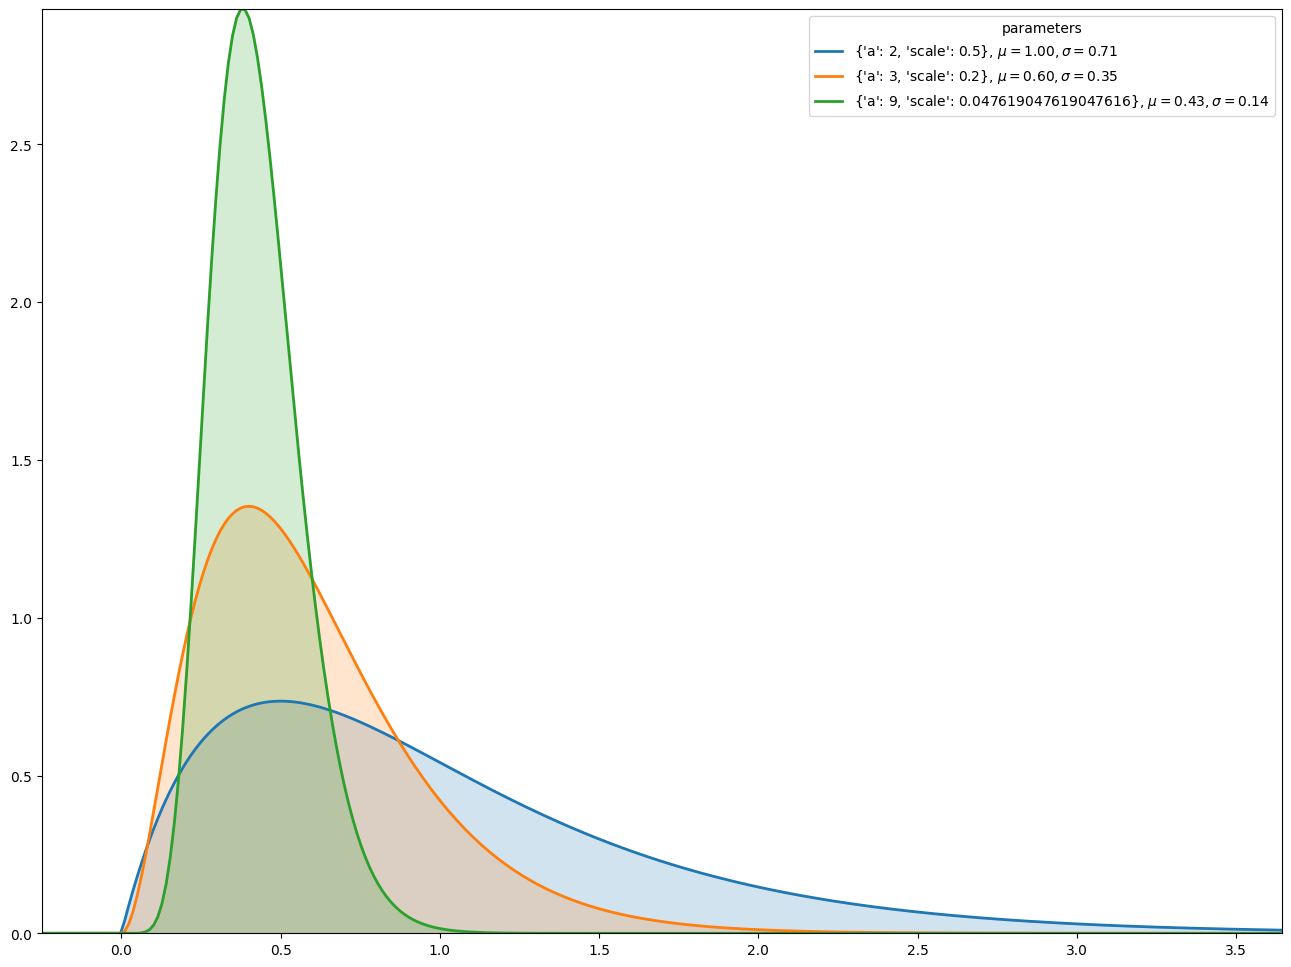

In [8]:
alpha0, beta0 = 2, 1
params_dispositivos = [(alpha0+k, beta0+t) for (k,t) in [
    (0,1), #0 fallos en un día
    (1,4), #1 fallos en 4 días
    (7,20), #7 fallos en 20 días
    ]]

gammas = [st.gamma(a=alpha, scale=1/beta)
          for alpha,beta in params_dispositivos
         ]

plot_dists(gammas)

### Interpretación de los parámetros de la Gamma(alpha, beta)

Ahora podemos dar una interpretación a los (hiper)parámetros de la distribución gamma, cuando la usamos para representar nuestro conocimiento sobre la tasa de un proceso de Poisson:

 - **alpha**: *número de fallos observados*
 - **beta**: *longitud del intervalo de tiempo durante los que se ha observado*

Es decir:
 - alpha/beta es la media: nuestra mejor aproximación para la tasa de fallos.
 - a igual media, cuanto más tiempo hayamos observado el proceso, menor la desviación típica => más convencidos estamos de conocer el auténtico valor de la tasa de fallo, porque tenemos más evidencia.

> Supongamos que operamos un servicio de paseos en barco con suelo de cristal para observar los fondos del Cabo de Gata. Aunque nunca hayamos visto una raya en la zona, sabemos que habitan en el mediterráneo. Pensamos que podemos observar una raya por salida, pero como no hemos salido nunca, tomamos un valor de beta pequeño. Pensamos que nuestras lecturas en internet corresponden a beta=0.5 salidas, y elegimos alpha=0.5 para que la media de avistamientos por salida sea de 1.

## Estadística bayesiana

El enfoque que hemos visto hoy se denomina **estadística bayesiana**, porque utiliza el teorema de Bayes para *aprender*.

El método de **máxima verosimilitud**, en contraste, no usa el teorema de Bayes, y no representa la incertidumbre sobre el valor del parámetro mediante una distribución de probabilidad.
Este enfoque pertenece a otras escuelas: la "*frecuentista*" y la _"likelihoodist"_ (no he conseguido encontrar una traducción), pero se puede interpretar como una simplificación del método bayesiano:

 - Se toma un prior uniforme.
 - Se reemplaza la distribución a posteriori por el valor donde alcanza el máximo.

Si únicamente usamos la segunda simplificación, pero con un prior no uniforme, obtenemos el estimador **MAP (maximum a posteriori)**.
En la comunidad de ingeniería, se suele interpretar el MAP como una versión _suavizada_ del estimador de máxima verosimilitud.

Comparemos la estimación de máxima verosimilitud con la estimación MAP para la tasa de un proceso de Poisson. Si en un periodo de longitud $T$ se producen $x$ observaciones, la estimación de máxima verosimilitud es $\frac{x}{T}$, mientras que la estimación MAP, para un prior $\lambda\sim\operatorname{Gamma}(\alpha,\beta)$, es $\frac{\alpha+x-1}{\beta+T}$.
La estimación de máxima verosimilitud corresponde al caso límite $a=1, b=0$.

Si $x=0$, la estimación de máxima verosimilitud es $\lambda^*=0$ (es decir, total seguridad de que el suceso no será observado nunca), mientras que $T$ muy pequeño dará estimaciones de $\lambda^*$ muy grandes.
Sin embargo, si $a>1$ y $b>0$, la estimación MAP no tomará valores tan extremos. El MAP no se acercará a $x=0$ hasta que no se haya observado un periodo de tiempo muy largo sin observaciones.

### Elegir la distribución a priori

Mucha gente evita el enfoque bayesiano porque no quiere tener que explicitar su conocimiento antes de tener datos. 
Es muy difícil estimar las probabilidades de los sucesos cuando no tenemos datos de experimentos u observaciones. El papel de la estadística consiste precisamente en estimar probabilidades en base a las observaciones.

No en vano, este enfoque a la estadística se corresponde a la interpretación *subjetiva* de la probabilidad, que es más general que el enfoque frecuentista, que sólo permite asignar distribuciones de probabilidad a sucesos repetibles, y nunca a cantidades fijas que no conocemos.

Cuando hayamos practicado un poco más el enfoque bayesiano, hablaremos de la escuela de **Estadística Bayesiana Objetiva**, que estudia las distintas formas de elegir distribuciones a priori *canónicas* u *objetivas*, en el sentido de que cualquier persona elegirá la misma distribución en cada situación.

### Ejercicio

Se instaura un nuevo sistema automatizado de gestión de containers en el puerto, que funciona durante 12 horas al día. Los promotores afirman que la tasa $\mu$ de containers mal procesados _al día_ será menor de dos, y nos pagarán una indemnización si es superior. Considerando sistemas similares en otros puertos, no sabemos si será menor o mayor que 2.
Finalmente, decidimos modelizar nuestra incertidumbre sobre $\mu$ mediante una distribución $\mu\sim\text{Gamma}(\alpha=3, \beta=2)$.

 - Dibuja la distribución que representa nuestra incertidumbre sobre $\mu$ antes de poner en marcha el sistema.
 - El primer container se extravió a las 3 horas de operación. Actualiza tu conocimiento sobre $\mu$, representa la nueva función de densidad.
 - Durante el resto del primer día, no hubo más incidencias. Actualiza tu conocimiento sobre $\mu$, representa la nueva función de densidad.
 - Al cabo de 5 días de operaciones, en total se habían procesado incorrectamente 8 containers. Actualiza tu conocimiento sobre $\mu$, representa la nueva función de densidad.
 - Calcula la probabilidad de que $\mu$ sea menor de dos containers al día, y de que sea mayor que 4 al día.

### Ejercicio

Para el mismo enunciado del ejercicio anterior: Una persona más escéptica representó su incertidumbre inicial mediante una Gamma(alpha=1, beta=0.25).

 - ¿Cuáles eran sus probabilidades a priori de $\mu\leq 2$ y $\mu\geq 4$?
 - Después de observar las operaciones durante los primeros días, ¿cuáles son ahora sus probabilidades a priori de $\mu\leq 2$ y $\mu\geq 4$? ¿se parecen a las probabilidades estimadas en el apartado anterior?